<a href="https://colab.research.google.com/github/MahamadSahjad/PRODIGY_INFOTECH_DS_TASK03/blob/main/PRODIGY_INFOTECH_DS_TASK03.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Decision Tree Classifier - Bank Marketing Dataset

**Objective:**  
Build a decision tree classifier to predict whether a customer will purchase a product or service based on their demographic and behavioral data using the **Bank Marketing dataset** from the UCI Machine Learning Repository.

**Steps Covered:**
1. Import required libraries
2. Load and inspect the dataset
3. Preprocess numeric and categorical data
4. Train Decision Tree Classifier with hyperparameter tuning
5. Evaluate model performance
6. Visualize results (Confusion Matrix, Feature Importances, Decision Tree)
7. Save the trained model


## 1. Import Required Libraries

In [1]:

import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import joblib
import urllib.request


## 2. Load Dataset

In [4]:
# Download from UCI if not found locally
download_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank-additional/bank-additional-full.csv"

# Define the local path for the dataset
local_path = "bank-additional-full.csv"

if os.path.exists(local_path):
    df = pd.read_csv(local_path, sep=';')
else:
    # Corrected URL
    download_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank-additional.zip"
    tmpfile = "bank-additional.zip"
    urllib.request.urlretrieve(download_url, tmpfile)
    # Extract the CSV from the zip file
    import zipfile
    with zipfile.ZipFile(tmpfile, 'r') as zip_ref:
        zip_ref.extractall(".")
    df = pd.read_csv("bank-additional/bank-additional-full.csv", sep=';')

print("Dataset shape:", df.shape)
df.head()

Dataset shape: (41188, 21)


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


## 3. Prepare Data

In [5]:

# Convert target to binary
df['y'] = df['y'].map({'yes': 1, 'no': 0})

# Split into features and target
target = 'y'
X = df.drop(columns=[target])
y = df[target]

# Identify numeric and categorical columns
numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()

numeric_cols, categorical_cols


(['age',
  'duration',
  'campaign',
  'pdays',
  'previous',
  'emp.var.rate',
  'cons.price.idx',
  'cons.conf.idx',
  'euribor3m',
  'nr.employed'],
 ['job',
  'marital',
  'education',
  'default',
  'housing',
  'loan',
  'contact',
  'month',
  'day_of_week',
  'poutcome'])

## 4. Preprocessing Pipeline

In [7]:
# Scale numeric data and One-Hot Encode categorical data
preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), numeric_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
])

## 5. Create Pipeline & Hyperparameter Tuning

In [8]:

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('clf', DecisionTreeClassifier(random_state=42))
])

param_grid = {
    'clf__criterion': ['gini', 'entropy'],
    'clf__max_depth': [3, 5, 7, 9, None],
    'clf__min_samples_split': [2, 5, 10]
}

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

# Grid Search CV
grid = GridSearchCV(pipeline, param_grid, cv=5, scoring='f1', n_jobs=-1)
grid.fit(X_train, y_train)

print("Best parameters:", grid.best_params_)
best_model = grid.best_estimator_


Best parameters: {'clf__criterion': 'gini', 'clf__max_depth': 3, 'clf__min_samples_split': 2}


## 6. Model Evaluation

Accuracy: 0.9119160920656502
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.95      0.95      9137
           1       0.61      0.59      0.60      1160

    accuracy                           0.91     10297
   macro avg       0.78      0.77      0.78     10297
weighted avg       0.91      0.91      0.91     10297

Confusion Matrix:
 [[8704  433]
 [ 474  686]]


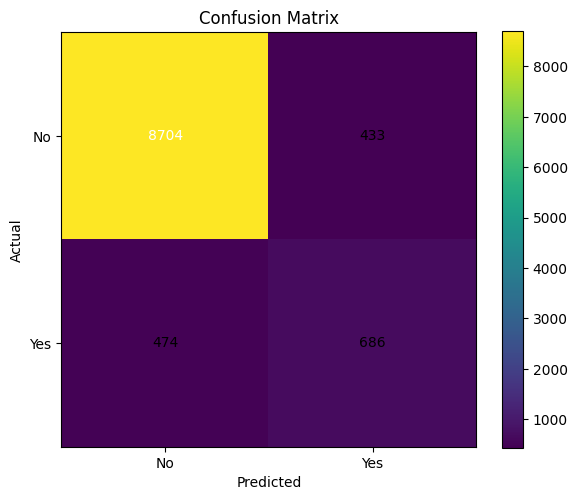

In [9]:

y_pred = best_model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)

# Plot confusion matrix
plt.figure(figsize=(6,5))
plt.imshow(cm, interpolation='nearest')
plt.title("Confusion Matrix")
plt.colorbar()
plt.xticks([0, 1], ['No', 'Yes'])
plt.yticks([0, 1], ['No', 'Yes'])
plt.xlabel('Predicted')
plt.ylabel('Actual')

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j], ha='center', va='center',
                 color="white" if cm[i, j] > cm.max()/2 else "black")
plt.tight_layout()
plt.show()


## 7. Feature Importances

Top 20 Features:
 duration             0.521668
nr.employed          0.394513
pdays                0.047637
cons.conf.idx        0.036181
previous             0.000000
campaign             0.000000
age                  0.000000
cons.price.idx       0.000000
emp.var.rate         0.000000
euribor3m            0.000000
job_admin.           0.000000
job_blue-collar      0.000000
job_entrepreneur     0.000000
job_housemaid        0.000000
job_management       0.000000
job_retired          0.000000
job_self-employed    0.000000
job_services         0.000000
job_student          0.000000
job_technician       0.000000
dtype: float64


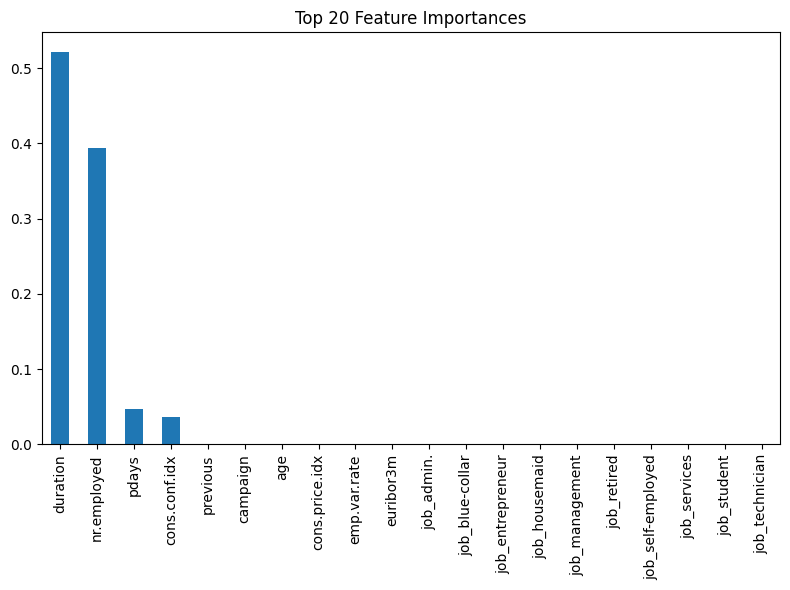

In [10]:

ohe = best_model.named_steps['preprocessor'].named_transformers_['cat']
if hasattr(ohe, 'get_feature_names_out'):
    ohe_names = ohe.get_feature_names_out(categorical_cols)
else:
    ohe_names = ohe.get_feature_names(categorical_cols)

feature_names = list(numeric_cols) + list(ohe_names)
clf = best_model.named_steps['clf']
importances = clf.feature_importances_

feat_imp = pd.Series(importances, index=feature_names).sort_values(ascending=False).head(20)
print("Top 20 Features:\n", feat_imp)

plt.figure(figsize=(8,6))
feat_imp.plot(kind='bar')
plt.title("Top 20 Feature Importances")
plt.tight_layout()
plt.show()


## 8. Decision Tree Visualization

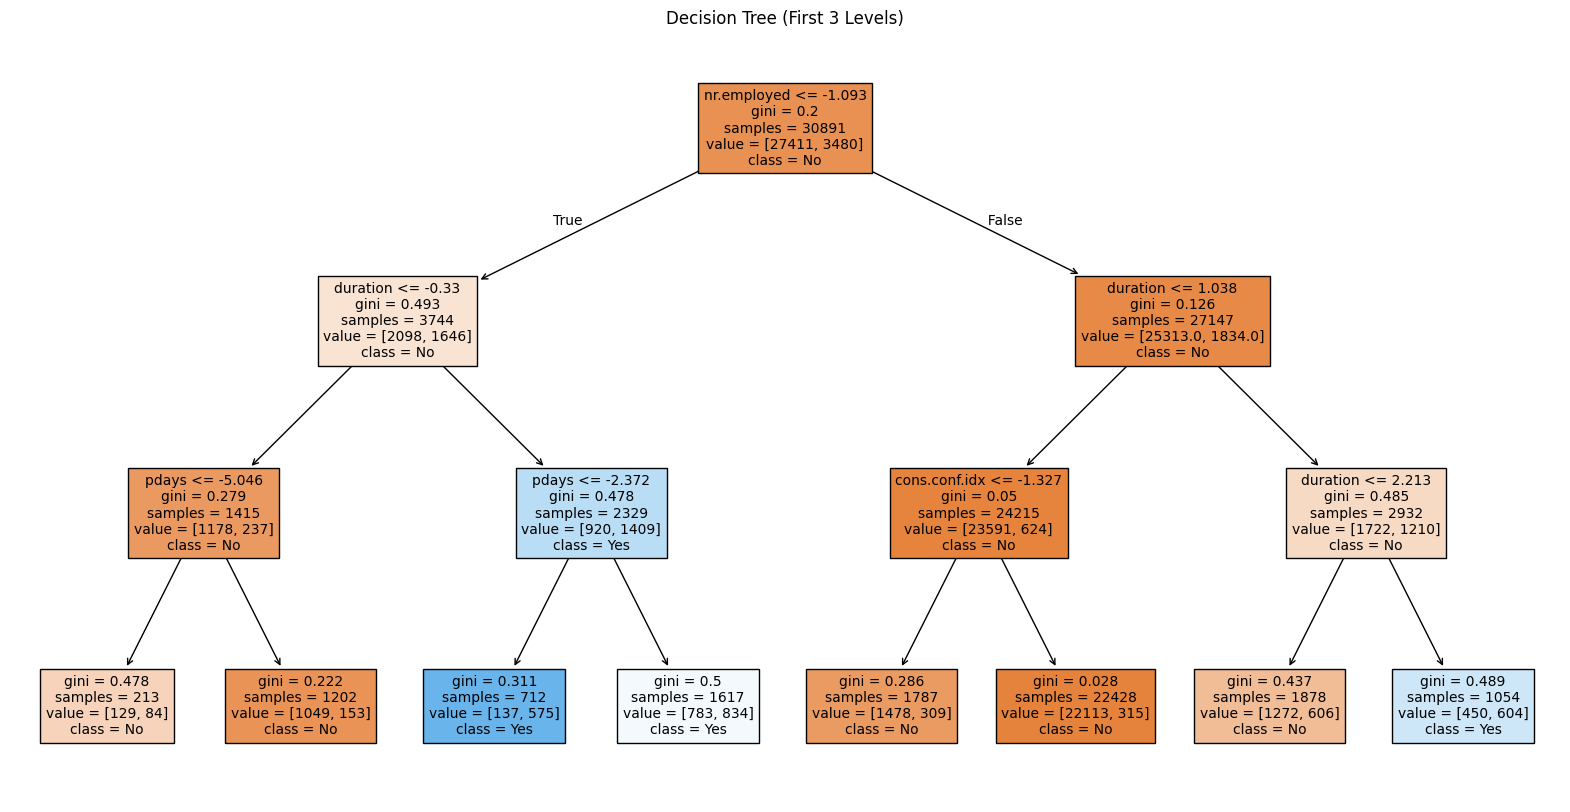

In [11]:

plt.figure(figsize=(20,10))
plot_tree(clf, feature_names=feature_names, class_names=['No','Yes'],
          filled=True, max_depth=3, fontsize=10)
plt.title("Decision Tree (First 3 Levels)")
plt.show()


## 9. Save Model

In [12]:

os.makedirs("models", exist_ok=True)
joblib.dump(best_model, "models/decision_tree_bank_model.joblib")
print("Model saved to models/decision_tree_bank_model.joblib")


Model saved to models/decision_tree_bank_model.joblib
